<a href="https://colab.research.google.com/github/gharashim/DL/blob/main/1d_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

# 시드 설정 (재현 가능한 결과를 위해)
np.random.seed(42)

def generate_fourier_regression_data(n_samples=1000,
                                     x_range=(-2*np.pi, 2*np.pi),
                                     n_harmonics=5,
                                     noise_level=0.3):
    """
    푸리에 급수 기반의 회귀 데이터 생성

    Parameters:
    - n_samples: 생성할 데이터 포인트 수
    - x_range: x값의 범위 (tuple)
    - n_harmonics: 사용할 조화파(harmonics)의 수
    - noise_level: 노이즈 강도

    Returns:
    - X: 입력 데이터 (n_samples, 1)
    - y: 출력 데이터 (n_samples,)
    """

    # x 값 생성 (균등 분포 + 약간의 랜덤성)
    x_min, x_max = x_range
    X = np.random.uniform(x_min, x_max, n_samples)
    X = np.sort(X)  # 시각화를 위해 정렬

    # 푸리에 급수 계수 (각 조화파에 대한 가중치)
    # 일반적으로 고차 조화파일수록 계수가 작아짐
    a0 = 2.0  # DC 성분

    # sin 계수들 (랜덤하게 생성하되, 고차일수록 작게)
    a_coeffs = np.random.normal(0, 1, n_harmonics) / np.arange(1, n_harmonics+1)

    # cos 계수들 (랜덤하게 생성하되, 고차일수록 작게)
    b_coeffs = np.random.normal(0, 1, n_harmonics) / np.arange(1, n_harmonics+1)

    # 푸리에 급수 계산
    y = np.ones_like(X) * a0/2  # DC 성분

    for n in range(1, n_harmonics+1):
        # n번째 조화파 추가
        y += a_coeffs[n-1] * np.cos(n * X) + b_coeffs[n-1] * np.sin(n * X)

    # 랜덤 노이즈 추가
    noise = np.random.normal(0, noise_level * np.std(y), n_samples)
    y += noise

    # X를 2차원 배열로 변환 (sklearn 호환성을 위해)
    X = X.reshape(-1, 1)

    return X, y, a0, a_coeffs, b_coeffs

def visualize_fourier_regression(X, y, X_train, y_train, X_test, y_test, a0, a_coeffs, b_coeffs):
    """
    시계열 회귀 데이터와 푸리에 계수를 시각화하는 함수

    Parameters:
        X (np.ndarray): 전체 입력 데이터 (1D or 2D)
        y (np.ndarray): 전체 타깃 데이터
        X_train (np.ndarray): 훈련 데이터 입력
        y_train (np.ndarray): 훈련 데이터 타깃
        X_test (np.ndarray): 테스트 데이터 입력
        y_test (np.ndarray): 테스트 데이터 타깃
        a0 (float): 푸리에 계수 a0
        a_coeffs (list or np.ndarray): 코사인 계수들 (a1, a2, ..., an)
        b_coeffs (list or np.ndarray): 사인 계수들 (b1, b2, ..., bn)
    """
    plt.figure(figsize=(15, 10))

    # 원본 함수 (노이즈 없이) 계산
    x_smooth = np.linspace(X.min(), X.max(), 1000)
    y_true = np.ones_like(x_smooth) * a0 / 2
    for n in range(1, len(a_coeffs) + 1):
        y_true += a_coeffs[n-1] * np.cos(n * x_smooth) + b_coeffs[n-1] * np.sin(n * x_smooth)

    # 서브플롯 1: 전체 데이터
    plt.subplot(2, 2, 1)
    plt.scatter(X_train.flatten(), y_train, alpha=0.6, s=20, c='blue', label='Train Data')
    plt.scatter(X_test.flatten(), y_test, alpha=0.6, s=20, c='red', label='Test Data')
    plt.plot(x_smooth, y_true, 'g--', linewidth=2, label='True Function (No Noise)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Generated Regression Data (All)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 서브플롯 2: 개별 조화파 성분들
    plt.subplot(2, 2, 2)
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    for n in range(1, min(len(a_coeffs)+1, 6)):
        harmonic = a_coeffs[n-1] * np.cos(n * x_smooth) + b_coeffs[n-1] * np.sin(n * x_smooth)
        plt.plot(x_smooth, harmonic, '--', color=colors[n-1], alpha=0.7, label=f'Harmonic {n}')
    plt.xlabel('x')
    plt.ylabel('Amplitude')
    plt.title('Individual Fourier Harmonics')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 서브플롯 3: 노이즈 분석
    plt.subplot(2, 2, 3)
    noise = y - (np.ones_like(X.flatten()) * a0 / 2)
    for n in range(1, len(a_coeffs)+1):
        noise -= a_coeffs[n-1] * np.cos(n * X.flatten()) + b_coeffs[n-1] * np.sin(n * X.flatten())
    plt.hist(noise, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Noise Value')
    plt.ylabel('Frequency')
    plt.title('Random Noise Distribution')
    plt.grid(True, alpha=0.3)

    # 서브플롯 4: 스펙트럼 분석 (FFT)
    plt.subplot(2, 2, 4)
    x_uniform = np.linspace(X.min(), X.max(), len(X))
    y_interp = np.interp(x_uniform, X.flatten(), y)
    fft_vals = np.fft.fft(y_interp)
    freqs = np.fft.fftfreq(len(y_interp), x_uniform[1] - x_uniform[0])
    pos_mask = freqs > 0
    plt.plot(freqs[pos_mask], np.abs(fft_vals[pos_mask]))
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.title('Frequency Spectrum (FFT)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


푸리에 급수 기반 회귀 데이터 생성 중...
생성된 데이터 형태:
X shape: (10, 1)
y shape: (10,)
X 범위: [0.06, 1.00]
y 범위: [0.48, 1.87]

사용된 푸리에 계수:
a0 (DC): 2.000
cos 계수: [-0.45006547  0.31142497 -0.35587348 -0.03559487  0.02405913  0.08573981
  0.10165927 -0.14058026 -0.17045713  0.12776768]
sin 계수: [ 0.33231401 -0.37424327  0.51705066  0.02891866  0.23585944  0.01125308
  0.29439256  0.21941761 -0.02766268  0.0971571 ]

데이터 분할:
훈련 데이터: 8 샘플
테스트 데이터: 2 샘플


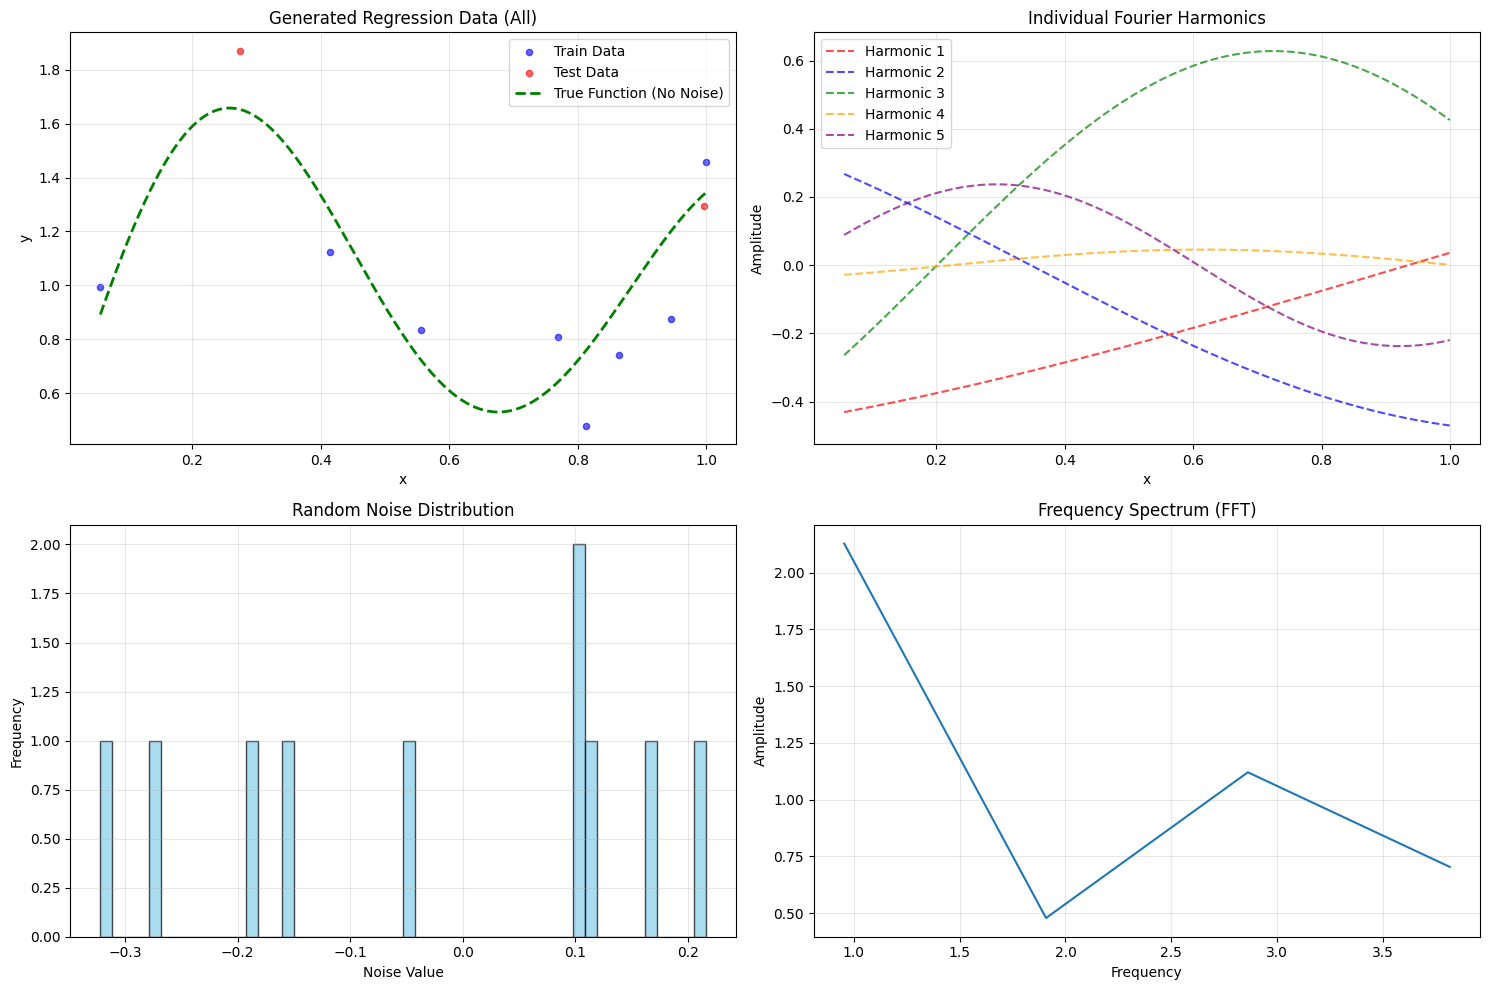

In [ ]:
# 데이터 생성
print("푸리에 급수 기반 회귀 데이터 생성 중...")
X, y, a0, a_coeffs, b_coeffs = generate_fourier_regression_data(
    n_samples=10,
    # x_range=(-3*np.pi, 3*np.pi),
    x_range=(0, 1),
    n_harmonics=10,
    noise_level=0.5
)

print(f"생성된 데이터 형태:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X 범위: [{X.min():.2f}, {X.max():.2f}]")
print(f"y 범위: [{y.min():.2f}, {y.max():.2f}]")

# 푸리에 계수 출력
print(f"\n사용된 푸리에 계수:")
print(f"a0 (DC): {a0:.3f}")
print(f"cos 계수: {a_coeffs}")
print(f"sin 계수: {b_coeffs}")

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n데이터 분할:")
print(f"훈련 데이터: {X_train.shape[0]} 샘플")
print(f"테스트 데이터: {X_test.shape[0]} 샘플")

visualize_fourier_regression(X, y, X_train, y_train, X_test, y_test, a0, a_coeffs, b_coeffs)


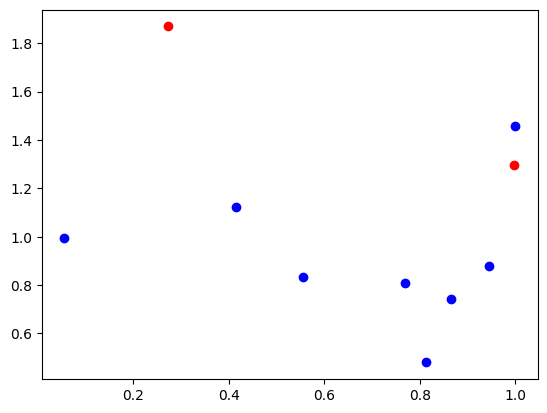

In [ ]:
plt.scatter(x = X_train, y = y_train, color = 'blue')
plt.scatter(x = X_test, y = y_test, color = 'red')

R² Scores (each fold): [0.74458833 0.86265452 0.69609199 0.43830438 0.71927435]
Mean R² Score: 0.6922
MSE (CV-based): 0.1259


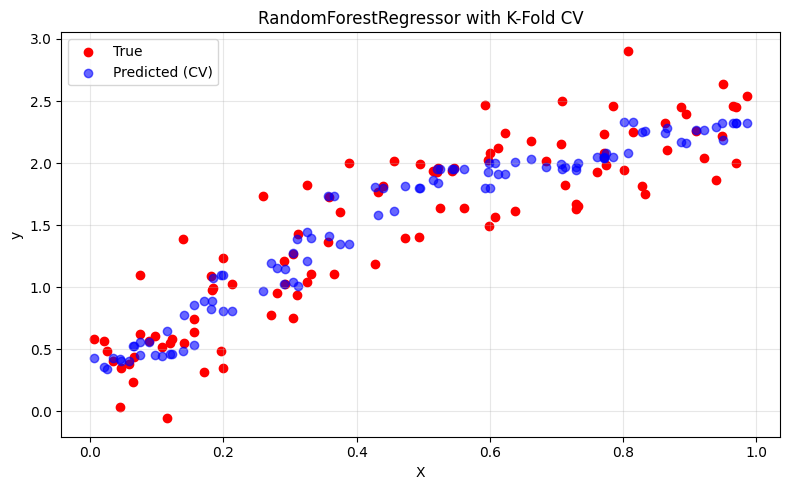

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

# 모델들 import
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# 2. 모델 선택 (하나만 주석 해제)
# model = LinearRegression()
model = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42)
# model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
# model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)

# 3. K-Fold 교차검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. R² 점수 평가
r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
print(f"R² Scores (each fold): {r2_scores}")
print(f"Mean R² Score: {np.mean(r2_scores):.4f}")

# 5. 예측값 생성 (CV 기반)
y_pred_cv = cross_val_predict(model, X, y, cv=kf)

# 6. 전체 MSE 평가
mse = mean_squared_error(y, y_pred_cv)
print(f"MSE (CV-based): {mse:.4f}")

# 7. 시각화
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='red', label='True')
plt.scatter(X, y_pred_cv, color='blue', alpha=0.6, label='Predicted (CV)')
plt.xlabel("X")
plt.ylabel("y")
plt.title(f"{model.__class__.__name__} with K-Fold CV")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# 2. PyTorch 텐서로 변환 (Conv1d용 reshape)
X = X.reshape(-1, 1, 1)           # (batch, channel, length)
y = y.reshape(-1, 1)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 3. 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

all_preds = []
all_true = []


# 4. 모델 정의 (2 Conv1d layers + Flatten + Linear)
class MLPRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

for fold, (train_idx, test_idx) in enumerate(kfold.split(X_tensor)):
    print(f"🌀 Fold {fold+1}")

    # Fold 별 데이터 준비
    X_train_fold = X_tensor[train_idx]
    y_train_fold = y_tensor[train_idx]
    X_test_fold = X_tensor[test_idx]
    y_test_fold = y_tensor[test_idx]

    # 모델 초기화 (Fold마다 새로 생성!)
    model = MLPRegressor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # 학습
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_fold)
        loss = criterion(output, y_train_fold)
        loss.backward()
        optimizer.step()

    # 예측
    model.eval()
    with torch.no_grad():
        preds = model(X_test_fold).numpy()
        true_vals = y_test_fold.numpy()

    all_preds.append(preds)
    all_true.append(true_vals)

# 전체 결과 평가
y_pred_cv = np.vstack(all_preds)
y_true_cv = np.vstack(all_true)

mse_cv = mean_squared_error(y_true_cv, y_pred_cv)
r2_cv = r2_score(y_true_cv, y_pred_cv)
print(f"\n📊 Cross-Validated MSE: {mse_cv:.4f}")
print(f"📈 Cross-Validated R²: {r2_cv:.4f}")


🌀 Fold 1


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🌀 Fold 2
🌀 Fold 3
🌀 Fold 4
🌀 Fold 5


ValueError: Found array with dim 3. None expected <= 2.

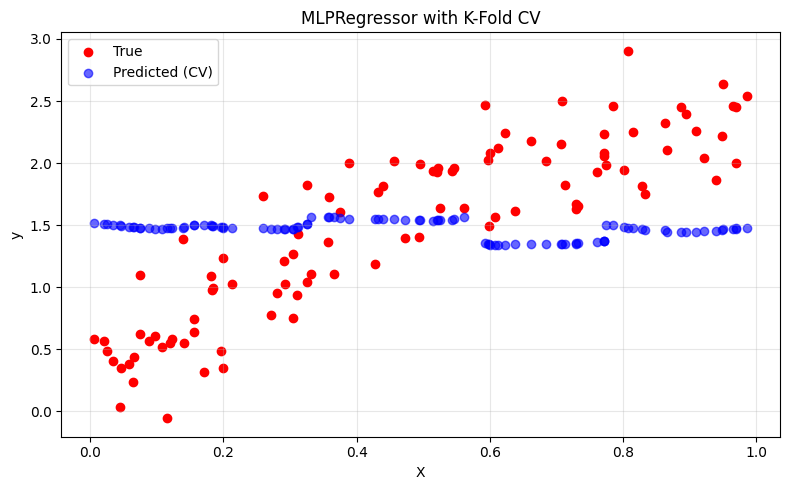

In [ ]:
# 7. 시각화
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='red', label='True')
plt.scatter(X, y_pred_cv, color='blue', alpha=0.6, label='Predicted (CV)')
plt.xlabel("X")
plt.ylabel("y")
plt.title(f"{model.__class__.__name__} with K-Fold CV")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 로딩
# data = fetch_california_housing()
# X = data.data
# y = data.target

# 2. 정규화
# scaler_X = StandardScaler()
# scaler_y = StandardScaler()
# X_scaled = scaler_X.fit_transform(X)
# y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# 3. 데이터 분할
# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y_scaled, test_size=0.2, random_state=42
# )

# 4. 텐서 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 5. 모델 정의
class MLPRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

model = MLPRegressor()

# 6. 학습 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 7. 학습 루프
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# 8. 예측
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test_tensor.numpy())

# 9. 평가
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"\n✅ Test MSE: {mse:.4f}")
print(f"✅ Test R² Score: {r2:.4f}")

# 10. 시각화
plt.figure(figsize=(12, 5))

# (1) 예측 vs 실제 산점도
plt.subplot(1, 2, 1)
plt.scatter(y_true, y_pred, alpha=0.5, color='blue')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted")

# (2) 잔차 분포
plt.subplot(1, 2, 2)
residuals = y_true - y_pred
plt.hist(residuals, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")

plt.tight_layout()
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (80x1 and 8x64)

In [ ]:
def visualize(y_true, y_pred):
    # 평가
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n✅ Test MSE: {mse:.4f}")
    print(f"✅ Test R² Score: {r2:.4f}")

    # 시각화
    plt.figure(figsize=(12, 5))

    # 예측 vs 실제 산점도
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Actual vs Predicted")

    # 잔차 분포
    plt.subplot(1, 2, 2)
    residuals = y_true - y_pred
    plt.hist(residuals, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("Residual Distribution")

    plt.tight_layout()
    plt.show()

Epoch 20/1000, Loss: 0.0920
Epoch 40/1000, Loss: 0.0742
Epoch 60/1000, Loss: 0.0732
Epoch 80/1000, Loss: 0.0727
Epoch 100/1000, Loss: 0.0727
Epoch 120/1000, Loss: 0.0727
Epoch 140/1000, Loss: 0.0727
Epoch 160/1000, Loss: 0.0727
Epoch 180/1000, Loss: 0.0727
Epoch 200/1000, Loss: 0.0727
Epoch 220/1000, Loss: 0.0727
Epoch 240/1000, Loss: 0.0727
Epoch 260/1000, Loss: 0.0726
Epoch 280/1000, Loss: 0.0726
Epoch 300/1000, Loss: 0.0726
Epoch 320/1000, Loss: 0.0726
Epoch 340/1000, Loss: 0.0726
Epoch 360/1000, Loss: 0.0725
Epoch 380/1000, Loss: 0.0724
Epoch 400/1000, Loss: 0.0723
Epoch 420/1000, Loss: 0.0721
Epoch 440/1000, Loss: 0.0718
Epoch 460/1000, Loss: 0.0712
Epoch 480/1000, Loss: 0.0704
Epoch 500/1000, Loss: 0.0693
Epoch 520/1000, Loss: 0.0679
Epoch 540/1000, Loss: 0.0662
Epoch 560/1000, Loss: 0.0639
Epoch 580/1000, Loss: 0.0597
Epoch 600/1000, Loss: 0.0516
Epoch 620/1000, Loss: 0.0378
Epoch 640/1000, Loss: 0.0255
Epoch 660/1000, Loss: 0.0196
Epoch 680/1000, Loss: 0.0176
Epoch 700/1000, Lo

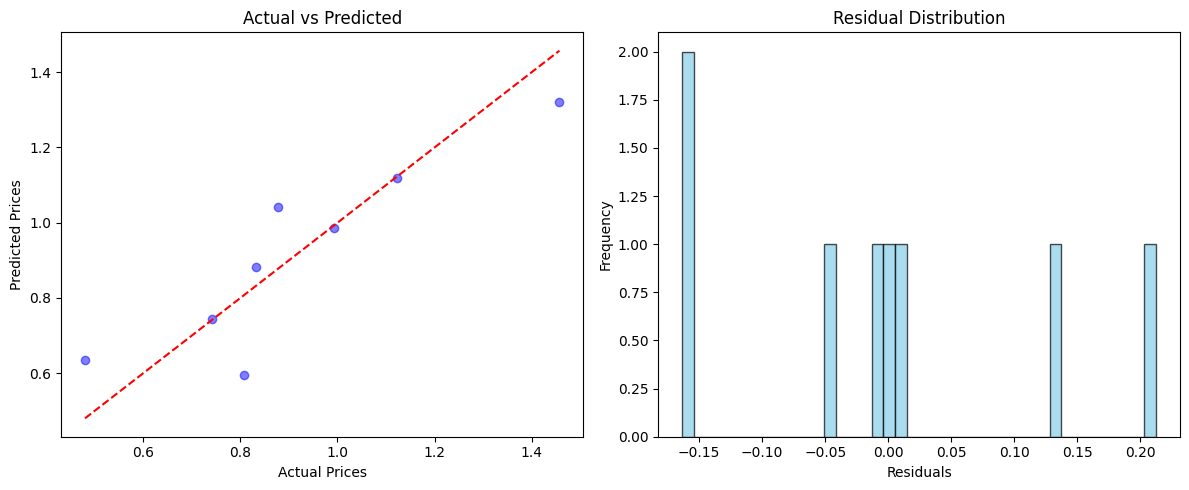

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# # 2. 정규화
# scaler_X = StandardScaler()
# scaler_y = StandardScaler()
# X_scaled = scaler_X.fit_transform(X)
# y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# # 3. 데이터 분할
# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y_scaled, test_size=0.2, random_state=42
# )

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


# 5. 모델 정의
class MLPRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

class ConvMLPRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=3, padding=1),  # 입력 1채널, 출력 8채널
            nn.BatchNorm1d(2),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.flatten = nn.Flatten()  # (B, 8, L) → (B, 8*L)

        self.mlp = nn.Sequential(
            nn.Linear(2 * 1, 8),   # 1은 Conv1d 출력 길이. 고정 길이인 경우 수정 가능
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            # nn.Linear(64, 64),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        # x: (B, 1) → (B, 1, 1)
        x = x.view(x.size(0), 1, -1)      # 채널 차원 추가: (B, 1, length)
        x = self.conv(x)                 # (B, 8, L)
        x = self.flatten(x)              # (B, 8 * L)
        x = self.mlp(x)
        return x

class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=10, dropout=0.1):
        super().__init__()

        # LSTM 레이어
        self.lstm = nn.LSTM(
            input_size=input_size,      # 입력 피처 수
            hidden_size=hidden_size,    # 히든 유닛 수
            num_layers=num_layers,      # LSTM 레이어 수
            dropout=dropout if num_layers > 1 else 0,  # 드롭아웃 (레이어가 2개 이상일 때만)
            batch_first=True           # (batch, seq, feature) 순서
        )

        # 출력 레이어
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        # x: (batch_size, sequence_length) → (batch_size, sequence_length, 1)
        if x.dim() == 2:
            x = x.unsqueeze(-1)

        # LSTM 통과
        lstm_out, (hidden, cell) = self.lstm(x)

        # 마지막 타임스텝의 출력 사용
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)

        # MLP 통과
        output = self.mlp(last_output)

        return output


# 단순 RNN 모델
class SmoothingRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(-1)  # 자동 차원 맞춤

        out, _ = self.rnn(x)  # out: (B, T, H)
        out = self.fc(out[:, -1, :])  # 마지막 시점의 은닉값
        return out

model = SmoothingRNN()

# model = MLPRegressor()
# model = ConvMLPRegressor()

# 모델 초기화
# model = LSTMRegressor(input_size=1, hidden_size=32, num_layers=2)

# 6. 학습 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 7. 학습 루프
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# 8. 예측
model.eval()
with torch.no_grad():
    y_pred = model(X_train_tensor).numpy().reshape(-1)
    y_true = y_train_tensor.numpy().reshape(-1)
    # y_pred = scaler_y.inverse_transform(y_pred_scaled)
    # y_true = scaler_y.inverse_transform(y_test_tensor.numpy())

visualize(y_true, y_pred)

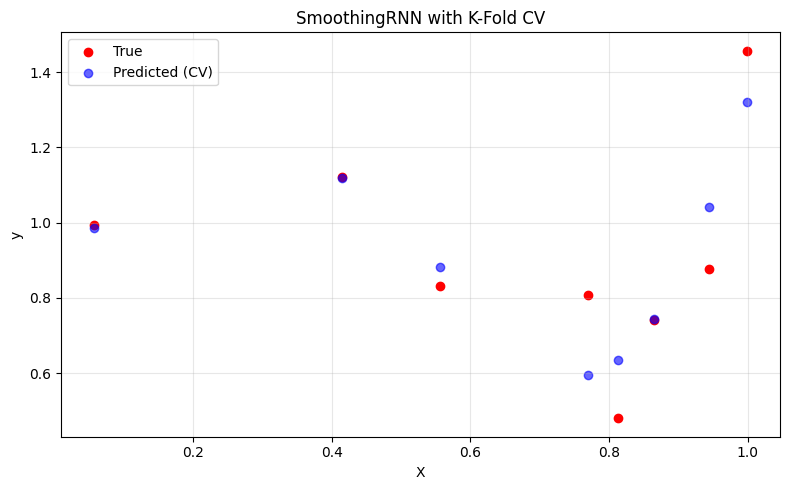

In [ ]:
# 7. 시각화
plt.figure(figsize=(8, 5))
plt.scatter(X_train, y_train, color='red', label='True')
plt.scatter(X_train, y_pred, color='blue', alpha=0.6, label='Predicted (CV)')
plt.xlabel("X")
plt.ylabel("y")
plt.title(f"{model.__class__.__name__} with K-Fold CV")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
